# Fine tuning GPT-2 to generate tarot card meanings and interpretations

After scraping texts from a number of sources, it's time to use them to re-train GPT-2 to generate new tarot card meanings, interpreations, and questions to ponder. 

[This article](https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93) by Richard Bownes, PhD has an amazing tutorial for fine tuning the [Hugging Face](https://huggingface.co/) GPT-2 model, and I've followed it here in this notebook to train and generate texts for this project.


### Sources & References
* [Fine tuning GPT-2 for Magic the Gathering Flavour text generation](https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93)
* [Fine tuning GPT-2... notebook](https://colab.research.google.com/drive/16UTbQOhspQOF3XlxDFyI28S-0nAkTzk_?authuser=1#scrollTo=U_XJVIetKN-h)
* [HuggingFace](https://huggingface.co/)

In [ ]:
# Install Hugging Face transformers 

%%capture
!pip install transformers

In [ ]:
import pandas as pd

In [ ]:
# GPU Check
!nvidia-smi

Wed Nov 25 23:24:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    50W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
fortunes_file = '/content/drive/MyDrive/gpt2/fortunes.txt'

with open(fortunes_file) as f:
    fortunes = f.read().split('\n')

In [ ]:
fortunes[:5]

['You don’t usually let your passions get the better of you but they will do so today. You won’t care in the slightest what other people think about what you do or say. That is, you won’t care today – tomorrow, however, you may be embarrassed!',
 'You are in the mood to shock. You want to see the look of amazement on other people’s faces when you say or do things they don’t approve of. Don’t go too far though or even your friends may start to avoid you. ',
 'You find beauty in ordinary things. Do not loose this ability.',
 'For quite some time someone you have dealings with has been trying to tell you that you mean more to them than just a friend or colleague. The question is, of course, what do they mean to you? Maybe it’s time to let them know. ',
 'The more you say the less others will listen, so give your tongue a rest and use your eyes and ears to find out what is going on. Something you see or hear over the next 24 hours will give you something worth talking about later on.']

In [ ]:
len(fortunes)

16810

### Reformatting dataset into sentence chunks

The documents of this corpus vary by length, and so I'll use SpaCy's sentencizer to break everything down into sentence chunks for processing with GPT-2 -- I think this should help with batch sizing and consistency of output.


In [ ]:
from spacy.lang.en import English

nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))

In [ ]:
chunks = len(fortunes)//10
print(f'Chunk size: {chunks}')

f1 = fortunes[:chunks]
f2 = fortunes[chunks:chunks*2]
f3 = fortunes[chunks*2:chunks*3]
f4 = fortunes[chunks*3:chunks*4]
f5 = fortunes[chunks*4:chunks*5]
f6 = fortunes[chunks*5:chunks*6]
f7 = fortunes[chunks*6:chunks*7]
f8 = fortunes[chunks*7:chunks*8]
f9 = fortunes[chunks*8:chunks*9]
f10 = fortunes[chunks*9:]

Chunk size: 1681


In [ ]:
f_list = [f1, f2, f3, f4, f5, f6, f7, f8, f9, f10]
f_list = [' '.join(f) for f in f_list]

for f in f_list:
  print(f'Doc length: {len(f)}')

Doc length: 352705
Doc length: 349488
Doc length: 350324
Doc length: 354850
Doc length: 352432
Doc length: 352201
Doc length: 347855
Doc length: 352206
Doc length: 349688
Doc length: 549588


In [ ]:
sentences = []

for f in f_list:
  s_words = []
  doc = nlp(f)
  s = [sent.string.strip() for sent in doc.sents]
  sentences.append(s)

In [ ]:
sentences = [s for sublist in sentences for s in sublist]

In [ ]:
sentences[0]

'You don’t usually let your passions get the better of you but they will do so today.'

In [ ]:
len(sentences)

38559

## GPT-2 Setup



### Tokenizer

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token = '<|startoftext|>',
                                          eos_token = '<|endoftext|>',
                                          pad_token = '<|pad|>'
                                          )

tokenizer.encode("Sample Text")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


[36674, 8255]

In [ ]:
fortunes = sentences.copy()
del sentences 

In [ ]:
max_fortune = max([len(tokenizer.encode(fortune)) for fortune in fortunes])

print(f'The longest text is {max_fortune} tokens long.')

The longest text is 269 tokens long.


### Setting up PyTorch Dataset & Dataloaders 

In [ ]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class TarotDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_fortune):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
      """
      This loop will iterate through each entry in the flavour text corpus.
      For each bit of text it will prepend it with the start of text token,
      then append the end of text token and pad to the maximum length with the 
      pad token. 
      """

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length"
                                 )
      
      """
      Each iteration then appends either the encoded tensor to a list,
      or the attention mask for that encoding to a list. The attention mask is
      a binary list of 1's or 0's which determine whether the langauge model
      should take that token into consideration or not. 
      """

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
from torch.utils.data import random_split

dataset = TarotDataset(fortunes, tokenizer, max_length=max_fortune)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

'There are 34703 samples for training, and 3856 samples for validation testing'

Setting up batch size and maximume token length for output text.

In [ ]:
#bs = 20 # most recent round --> this worked pretty well
bs = 18
max_fortune = 100

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset), 
    batch_size = bs
    )

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = bs
    )

### Setting GPT-2 model parameters

In [ ]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Optional step to enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 4
warmup_steps = 1e2
sample_every = 100

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), 
                  lr = 2e-4,          # Learning rate (reduced from 5e-4)
                  eps = 1e-8
                  )

In [ ]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps
                                            )

### Setting up the training loop!

In [ ]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}...')
    print('--------------------------------------------------------------------\n')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(b_input_ids,
                        labels=b_labels, 
                        attention_mask = b_masks,
                        token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            
            for i, sample_output in enumerate(sample_outputs):
                  print(f'----> Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print('\n--------------------------------------------------------------------')
    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')
    print('--------------------------------------------------------------------')
    
    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print('\n--------------------------------------------------------------------')
    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')
    print('--------------------------------------------------------------------\n')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
        )

print('====================================================================\n')
print('Training complete!')
print(f'Total training time: {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 4...
--------------------------------------------------------------------



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2169. Loss:0.2714158594608307. Time:0:00:39
	Example output:  bipartisanA good deal of work is done here.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2169. Loss:0.24938304722309113. Time:0:01:18
	Example output:  increasingThe fact is, if you put words in your mouth, it will turn you upside down and turn you into someone more likely to be upset or disappointed.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2169. Loss:0.22656399011611938. Time:0:01:57
	Example output: dayThe Sun and Mercury warn that all things will be possible once you get the confidence back in your heart you can start making changes in it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2169. Loss:0.239750474691391. Time:0:02:36
	Example output:  HangThe planet is moving forward.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2169. Loss:0.1974717676639557. Time:0:03:15
	Example output:  foodsThe earth is one hundred percent flat, and one of the most interesting things which is all about life in an eternal scheme is that the planets are everywhere concerned as well as your friends.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2169. Loss:0.2420227825641632. Time:0:03:54
	Example output:  trailBy all means get.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2169. Loss:0.21219101548194885. Time:0:04:33
	Example output: intendThe planets indicate your priorities will be balanced over the next 24 hours – that is, until Jupiter moves out of your sign of Cancer, just before you lose your balance.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2169. Loss:0.24048376083374023. Time:0:05:13
	Example output:  surroundToday’s Sun-Jupiter link will boost your confidence but your dreams will be a bit more challenging than usual.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2169. Loss:0.18715070188045502. Time:0:05:52
	Example output:  reflexA project for which no doubt someone on a team will be delighted is over.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2169. Loss:0.2143394947052002. Time:0:06:31
	Example output:  displayIf you are being dishonest you may think you are being dishonest but you are a fool.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2169. Loss:0.21988944709300995. Time:0:07:10
	Example output:  pastorIf you can find yourself in a position where you are unable to help, then do something about it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2169. Loss:0.2707863748073578. Time:0:07:49
	Example output:  illicitYou need to be careful with money.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2169. Loss:0.23551765084266663. Time:0:08:28
	Example output:  LiberationThe more you push the harder it gets to get rid of the old.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2169. Loss:0.20390449464321136. Time:0:09:07
	Example output:  NamWe don’t know how to stop him from doing what he has to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2169. Loss:0.2159050703048706. Time:0:09:46
	Example output: IONIs a good time to discuss issues of a partnership nature and can you explain why the relationship is worth fighting for?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2169. Loss:0.2419460415840149. Time:0:10:26
	Example output:  glimpseYou have taken liberties over the past few weeks that make you a bit suspicious of people who can speak to you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2169. Loss:0.20946982502937317. Time:0:11:05
	Example output:  LaureDon’t think you can reach your goals, because if you can do it you can do so too.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2169. Loss:0.32523712515830994. Time:0:11:44
	Example output: ismYou should be doing better and maybe making up for it today.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2169. Loss:0.22738991677761078. Time:0:12:23
	Example output: ounThe Sun’s move into the most adventurous area of your chart today will put you on the right path to success but for now you must keep a low profile – and stick with your plan.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2169. Loss:0.21155232191085815. Time:0:13:03
	Example output:  electionThe way they see things may seem to you to be the wrong way round but that is exactly what you need to know.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2169. Loss:0.2404232621192932. Time:0:13:42
	Example output:  crazyIf you do not follow the path of best policy you will find that it takes you more to get the best out of life than it does to get the best out of people.
Average Training Loss: 0.3023587040098211. Epoch time: 0:14:09
Validation loss: 0.2109279956560412. Validation Time: 0:00:29

--------------------------------------------------------------------

Beginning epoch 2 of 4...
--------------------------------------------------------------------



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2169. Loss:0.24570006132125854. Time:0:00:39
	Example output:  benchAs Mercury, your ruler, moves through the most dynamic area of your chart today you will find it very easy to express yourself creatively.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2169. Loss:0.20445720851421356. Time:0:01:18
	Example output:  incorporatedThe planets warn if you try to hide something from people in positions of power you might regret it later on when your life is done in good time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2169. Loss:0.2319791615009308. Time:0:01:58
	Example output: PeterWhat is the danger, if you are allowed to be a bit touchy over the next 48 hours?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2169. Loss:0.27548354864120483. Time:0:02:37
	Example output: uringWhat is it about your body that makes you so special?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2169. Loss:0.2134721279144287. Time:0:03:16
	Example output:  reproductiveIf a family member you care for gives you financial assistance then by all means get in touch – there will be consequences.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2169. Loss:0.23141688108444214. Time:0:03:55
	Example output:  zoneWhat may have been a challenging day for you will now be a challenging day for the rest of the world.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2169. Loss:0.2068156599998474. Time:0:04:35
	Example output:  commitsIt may seem as if life is being run by magic and you have no control over it but that does not mean you have to worry about it – and you do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2169. Loss:0.2005896270275116. Time:0:05:14
	Example output:  ironyThere may be times in which you seem impatient but the planets indicate it is time for a vacation.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2169. Loss:0.2244681864976883. Time:0:05:53
	Example output:  SahThere is no point trying to force others to see things your way – they will come to nothing.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2169. Loss:0.1852504462003708. Time:0:06:32
	Example output:  BryanWhat happens today will determine how you manage your workload and help make a success of it.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2169. Loss:0.21315240859985352. Time:0:07:11
	Example output:  spiritsWhat comes next is more important than what you can see so far.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2169. Loss:0.1931728571653366. Time:0:07:51
	Example output:  seesThis card represents a man in the guise of a shipwrecks, whose passengers are sailing round in a circle, and carrying three or four passengers who are called upon to carry them round in the utmost, without passengers strength.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2169. Loss:0.2506088316440582. Time:0:08:30
	Example output:  hungryWhat happens over the next few days will most likely convince you to give it another go.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2169. Loss:0.2456158846616745. Time:0:09:09
	Example output:  PTYou are entitled to your opinions about something but, under no circumstances, do you do them retrograde, or do you go the other way and say they were wrong?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2169. Loss:0.1937330961227417. Time:0:09:49
	Example output: üTake risks, work hard and enjoy the best quality of life.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2169. Loss:0.1706102341413498. Time:0:10:28
	Example output: ruceIt isn’t nearly as bad as you thought it would be, so stop playing around and make your dream come true.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2169. Loss:0.23884844779968262. Time:0:11:07
	Example output:  derivativesYou will get the chance to make some serious money over the next 48 hours.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2169. Loss:0.17578400671482086. Time:0:11:46
	Example output: Your words may be harsh but the planets indicate you are being reasonable about yourself.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2169. Loss:0.21252427995204926. Time:0:12:25
	Example output:  rememberingDon’t worry about money or business matters today.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2169. Loss:0.18526537716388702. Time:0:13:04
	Example output:  SourcesNo matter how hard you try to get through to other people today you are advised to stick to your guns.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2169. Loss:0.16108858585357666. Time:0:13:43
	Example output: emsFor some strange reason you are feeling restless at the moment and a great deal of your time and energy should be directed to other activities.
Average Training Loss: 0.20085017875338437. Epoch time: 0:14:10
Validation loss: 0.20263195139862195. Validation Time: 0:00:29

--------------------------------------------------------------------

Beginning epoch 3 of 4...
--------------------------------------------------------------------



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2169. Loss:0.26342442631721497. Time:0:00:39
	Example output: tzBut why?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2169. Loss:0.16736893355846405. Time:0:01:18
	Example output: maticWhatever your intentions you must refuse to make them known.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2169. Loss:0.1630270630121231. Time:0:01:57
	Example output:  syndDon’t go making deals because it will backfire on you.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2169. Loss:0.1535690277814865. Time:0:02:36
	Example output:  gamWhat is more, it furthers one person’s career to suffer when they make enemies.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2169. Loss:0.23649007081985474. Time:0:03:15
	Example output:  injuryThere will be plenty of bad news this week, both on the home front and at work, so make sure you know what is going to happen.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2169. Loss:0.20033922791481018. Time:0:03:54
	Example output: azaJust be careful you don’t lose something that makes you smile.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2169. Loss:0.1655333936214447. Time:0:04:33
	Example output:  membraneThere is a danger that it could be too cynical to get ahead, and it won’t be for you at least.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2169. Loss:0.18830238282680511. Time:0:05:13
	Example output: ijingThe Sun’s change of signs today will in some way or other bring your confidence back and you will soon be back where you were before.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2169. Loss:0.16578903794288635. Time:0:05:52
	Example output:  castWhat happens over the next few days will convince you that there is no point trying to do anything drastic, that it is your responsibility to be positive and that you need to stay on good terms with everyone.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2169. Loss:0.1615721583366394. Time:0:06:31
	Example output:  purchMake sure those who need help are aware that their financial situation is far from improving.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2169. Loss:0.15356981754302979. Time:0:07:10
	Example output:  shouldersIt is a cardinal sign that if you act on what you hear over the next 24 hours you will get what you want from the people you meet over the next 24 hours.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2169. Loss:0.184514120221138. Time:0:07:50
	Example output:  builtYou will get every opportunity to show the world how far you have come and how much you intend to push yourself beyond your natural limits over the next two or three days.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2169. Loss:0.1922888606786728. Time:0:08:29
	Example output:  openlyYou’re certainly not a stranger to criticism – never mind to the point of being so angry – so why are you being so sensitive?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2169. Loss:0.17773789167404175. Time:0:09:08
	Example output:  haltedYou may be eager to get things done but you must not allow your physical, emotional or financial needs to get in the way.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2169. Loss:0.17762455344200134. Time:0:09:48
	Example output:  NikBehold, my hand moves quickly; behold, the dragon hath wings like unto his lion, and his tail beats his head, and his mouth beats up his tongue to the heaven of the saints.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2169. Loss:0.19663964211940765. Time:0:10:27
	Example output:  tinYou don’t need it though, because the only problem is that you may be feeling sorry for someone who has lost their temper.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2169. Loss:0.1584712117910385. Time:0:11:06
	Example output:  clinicalYou can’t get rid of them.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2169. Loss:0.21334074437618256. Time:0:11:45
	Example output: lectionsThe time of your ultimate determination has arrived, but there is still a time.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2169. Loss:0.14124445617198944. Time:0:12:24
	Example output: elsAccording to the planets you have got it wrong.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2169. Loss:0.21089178323745728. Time:0:13:03
	Example output: labYour confidence is sky high at the moment and the fact is you can’t do all the things you normally do!


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2169. Loss:0.207636758685112. Time:0:13:42
	Example output:  tripleYes, you really have to be on top of the world.
Average Training Loss: 0.18169695134809238. Epoch time: 0:14:09
Validation loss: 0.19895296707687538. Validation Time: 0:00:29

--------------------------------------------------------------------

Beginning epoch 4 of 4...
--------------------------------------------------------------------



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 2169. Loss:0.18065735697746277. Time:0:00:39
	Example output: 220It is not a pleasant feeling.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 2169. Loss:0.14207567274570465. Time:0:01:18
	Example output:  SeeNo matter how many times you have failed in the past you will soon be back to what you are trying so hard to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 2169. Loss:0.1634426862001419. Time:0:01:57
	Example output: @@You have been far too suspicious of late and now you need to get the evidence you need to make sure you don’t go off into another direction.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 2169. Loss:0.1300000697374344. Time:0:02:36
	Example output:  hostIt is true that you are on the down side of the curve when it comes to money matters but in some ways it’s also true that you are on top of the curve.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 2169. Loss:0.12931041419506073. Time:0:03:16
	Example output: roleYou are who you are for a reason and that’s something that needs to be understood.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 2169. Loss:0.17290762066841125. Time:0:03:55
	Example output: iacAccording to the planets the only danger this week is you may spend too much time looking back and hoping you can get away with something you are not supposed to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 2169. Loss:0.17083610594272614. Time:0:04:34
	Example output:  LDYou may believe that being able to control your temper is a way to "stay out of trouble" but in the greater scheme of things it isn’t.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 2169. Loss:0.15766343474388123. Time:0:05:14
	Example output:  ListenYou don’t have to be afraid of what others might think of you, you just have to be willing to take risks and risk everything.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 2169. Loss:0.1476852148771286. Time:0:05:53
	Example output:  dyYou need to be a bit more flexible and try to stay on the straight and narrow over the next few days, especially on the career front.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 2169. Loss:0.16584162414073944. Time:0:06:32
	Example output:  DomesticDon’t push yourself too hard today because what happens this weekend will make you dynamic enough to carry on in the present.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 2169. Loss:0.14428770542144775. Time:0:07:11
	Example output:  beneficiariesIf you go looking for it today don’t give up hope.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 2169. Loss:0.1796332597732544. Time:0:07:50
	Example output:  TitleMake it easy for you to be assertive today, even if you think it’s the last thing you need to do.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 2169. Loss:0.16442589461803436. Time:0:08:30
	Example output:  μIf you are wise you will use it to get what you want this weekend, but if you are not it could cost you more.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 2169. Loss:0.1719135046005249. Time:0:09:09
	Example output:  sellingYou will learn something today or tomorrow that others have missed, simply because they don’t realize how easy it is.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 2169. Loss:0.21505841612815857. Time:0:09:48
	Example output:  migrantYes, of course, you have responsibilities of your own, but as an Aries they can do as they please.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 2169. Loss:0.1639297604560852. Time:0:10:27
	Example output: ivelyYour instincts are telling you that you will be thrust into the spotlight without a backward glance, but can you really expect them to be so dynamic?


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 2169. Loss:0.2207673043012619. Time:0:11:07
	Example output:  orderA lot is changing in your world at the moment and as the week moves on it will be clear what needs to be done to make life better.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 2169. Loss:0.2133551836013794. Time:0:11:46
	Example output:  VPNSomething that has kept you attached to the past will be swept away over the next few days.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 2169. Loss:0.169855996966362. Time:0:12:25
	Example output:  explanationDon’t waste time lamenting what went wrong and don’t go over the top.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 2169. Loss:0.15450499951839447. Time:0:13:04
	Example output:  BachBut for when we define the ego—self-consciousness as the spontaneous movement of human consciousness between conscious and unconscious—that is the only meaningful unity which can have between the two.


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 2169. Loss:0.1744973361492157. Time:0:13:43
	Example output:  folderThis is potentially one of the best weekends of the year for you as Mercury moves into your opposite sign of Pisces tomorrow.
Average Training Loss: 0.164469825532399. Epoch time: 0:14:10
Validation loss: 0.19929574408348172. Validation Time: 0:00:29

--------------------------------------------------------------------


Training complete!
Total training time: 0:58:37


### Model Evaluation

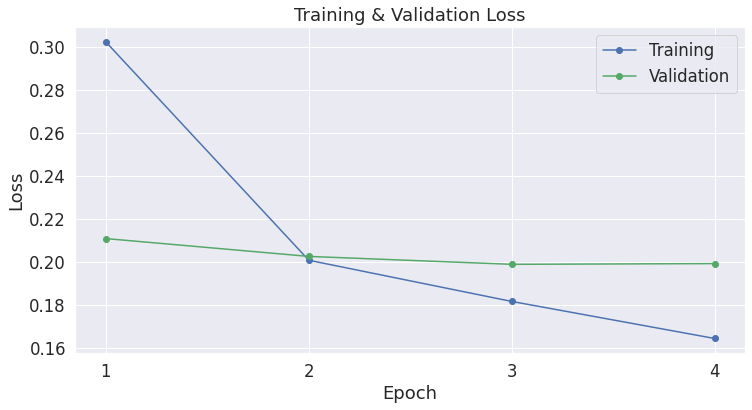

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

Looks like there's a bit of overfitting happening towards the end of the training loop -- I'll sample some output and decide whether or not train again.

In [ ]:
model.eval()

prompt = "<|startoftext|>"
#prompt = 'How can'
#prompt = 'The '

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))  

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: If you say too much it may be necessary to hurt a friend’s feelings.

1: You will go out of your way today to impress people in positions of authority, even those who clearly don’t share your principles.

2: That applies especially to your work as it will pay you to be a bit more assertive today.

3: The planets warn you could easily go over the top and let slip some kind of personal advantage.

4: If you come across as rude and uncaring today then by all means make a few apologies.

5: Your confidence is sky-high at the moment and that’s good because a new solar year begins very soon, so don’t give up on a plan yet.

6: The more certain people tell you that you should not fight against them the more determined you should be to do the right thing, to stay on top of the facts.

7: You seem a bit fragile at the moment.

8: You are not that far behind the curve when it comes to other people’s achievements.

9: You’ve got the talent, but it takes an individual to be superhuman – and you

I'm pretty happy with this - I'll save the model and generate output for the cards in the next notebook.

## Saving the model

In [ ]:
dir = '/content/drive/MyDrive/gpt2/models'
model_folder = '/model_2'

output_dir = dir + model_folder


model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('/content/drive/MyDrive/gpt2/models/model_2/tokenizer_config.json',
 '/content/drive/MyDrive/gpt2/models/model_2/special_tokens_map.json',
 '/content/drive/MyDrive/gpt2/models/model_2/vocab.json',
 '/content/drive/MyDrive/gpt2/models/model_2/merges.txt',
 '/content/drive/MyDrive/gpt2/models/model_2/added_tokens.json')